# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")


## Data Exploring and Data Cleaning

In [2]:
churn = pd.read_csv("data/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
churn.shape

(46206, 21)

### <center>Mobile Churn Data Dictionary</center>

|   Variable_name  	|   Description  	|
|:--	|:--	|
|   CUST_ID  	|   Unique customer identifier  	|
|   ACCOUNT_TENURE  	|   Account tenure in months based on last day of reporting month  	|
|   ACCT_CNT_SERVICES  	|   Total number of services under an account  	|
|   AGE  	|   Age of the account holder (derived on dob)  	|
|   CFU  	|   Customer facing unit derived based on owning cost centre  	|
|   SERVICE_TENURE  	|   Service tenure in months  	|
|   PLAN_ACCESS_FEE  	|   Monthly access fee payable for the plan excluding gst  	|
|   BYO_PLAN_STATUS  	|   Whether the customer is on a BYO (bring your own) plan  	|
|   PLAN_TENURE  	|   Plan tenure in months  	|
|   MONTHS_OF_CONTRACT_REMAINING  	|   Contract tenure remaining based on months of contract completed  	|
|   LAST_FX_CONTRACT_DURATION  	|   Last known fixed contract term  	|
|   CONTRACT_STATUS  	|   Based on current contract the service is either on 'no-contract', 'on-contract' or 'off-contract'  	|
|   PREV_CONTRACT_DURATION  	|   Previous contract term  	|
|   HANDSET_USED_BRAND  	|   Used equipment brand  	|
|   CHURN_IND  	|   Service churn flagging for disconnected service in reporting month  	|
|   MONTHLY_SPEND  	|   Service spend for reporting month  	|
|   COUNTRY_METRO_REGION  	|   Country or metro customer classification  	|
|   STATE  	|   State location of registered service  	|
|   RECON_SMS_NEXT_MTH  	|   Recontracted after SMS contact in the following month  	|
|   RECON_TELE_NEXT_MTH  	|   Recontracted after personal telephone contact in the following month  	|
|   RECON_EMAIL_NEXT_MTH  	|   Recontracted after email contact in the follwing month  	|

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46130 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

In [5]:
churn.describe(include="all")

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206,46206.000000,46206.000000,46206,46206.000000,46206.000000,...,46206,46206.000000,46206,46206.000000,46206.000000,46205,46205,28416.000000,28416.000000,28416.000000
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,NaN,...,3,NaN,6,NaN,NaN,2,8,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,CONSUMER,NaN,NaN,NON BYO,NaN,NaN,...,ON-CONTRACT,NaN,APPLE,NaN,NaN,METRO,NSW,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,39087,NaN,NaN,35475,NaN,NaN,...,28281,NaN,24805,NaN,NaN,31826,15867,NaN,NaN,NaN
mean,42335.196879,45.874627,1.555707,41.411836,NaN,50.318617,51.364858,NaN,10.846708,8.237112,...,NaN,15.249968,NaN,0.385015,75.188029,NaN,NaN,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,NaN,51.925537,20.855419,NaN,9.769887,8.341476,...,NaN,10.982958,NaN,0.486604,73.519041,NaN,NaN,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,NaN,0.000000,8.180000,NaN,0.000000,0.000000,...,NaN,0.000000,NaN,0.000000,1.020000,NaN,NaN,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,NaN,11.000000,36.360000,NaN,3.000000,0.000000,...,NaN,0.000000,NaN,0.000000,36.360000,NaN,NaN,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,NaN,35.000000,54.540000,NaN,8.000000,7.000000,...,NaN,24.000000,NaN,0.000000,54.540000,NaN,NaN,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,NaN,69.000000,72.720000,NaN,16.000000,16.000000,...,NaN,24.000000,NaN,1.000000,84.530000,NaN,NaN,0.000000,0.000000,0.000000


In [6]:
# check NA values
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

In [7]:
# drop useless columns and na values
churn2 = churn.drop(columns=['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'])
clean_churn = churn2.dropna()
clean_churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


In [8]:
# remove abnormal values in age
clean_churn = clean_churn.drop(clean_churn.index[clean_churn['AGE'] <= 0], inplace = False)
clean_churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,42336.772498,45.886856,1.554426,41.413576,50.364234,51.361234,10.850890,8.235090,20.351118,15.253192,0.385067,75.169090
std,22102.538850,33.073946,0.834363,15.261213,51.943989,20.854056,9.771842,8.339843,8.032833,10.981573,0.486616,73.393772
min,1.000000,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24950.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43262.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61136.500000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


In [9]:
clean_churn.shape

(46127, 18)

### Predict Variable: Churn Index

In [10]:
# check the values in the CHURN_IND field (Predict variable)
# 0 = still using ther services
# 1 = churned / left the services
clean_churn.CHURN_IND.value_counts()

0    28365
1    17762
Name: CHURN_IND, dtype: int64

<AxesSubplot:xlabel='CHURN_IND', ylabel='count'>

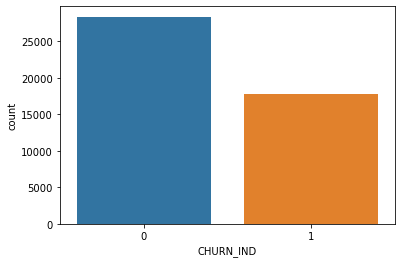

In [11]:
sns.countplot(x='CHURN_IND', data=clean_churn)

In [12]:
#calculate churn rate
churn_rate = len(clean_churn[clean_churn['CHURN_IND']==1])/len(clean_churn['CHURN_IND'])
print(f'Churn rate is: {round((churn_rate*100),2)}%')

Churn rate is: 38.51%


In [13]:
# check correlations for numerical variables
clean_churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
CUST_ID,1.000000,0.080856,0.029840,0.064905,0.080131,0.017545,-0.061971,0.116854,0.037339,0.034796,-0.496496,-0.086338
ACCOUNT_TENURE,0.080856,1.000000,0.197913,0.250559,0.792277,-0.084736,0.247495,-0.170542,0.177226,0.504281,-0.151812,-0.138259
ACCT_CNT_SERVICES,0.029840,0.197913,1.000000,0.157473,0.069596,-0.003732,-0.041169,0.023126,0.001373,0.021832,-0.062352,-0.019340
AGE,0.064905,0.250559,0.157473,1.000000,0.251750,-0.347297,0.053682,-0.185673,-0.143433,0.008339,-0.115242,-0.209441
SERVICE_TENURE,0.080131,0.792277,0.069596,0.251750,1.000000,-0.078511,0.218010,-0.143773,0.139667,0.411052,-0.153827,-0.115689
PLAN_ACCESS_FEE,0.017545,-0.084736,-0.003732,-0.347297,-0.078511,1.000000,-0.058188,0.470619,0.393498,0.135902,-0.036616,0.448546
PLAN_TENURE,-0.061971,0.247495,-0.041169,0.053682,0.218010,-0.058188,1.000000,-0.429862,0.125981,0.184041,0.141735,-0.058086
MONTHS_OF_CONTRACT_REMAINING,0.116854,-0.170542,0.023126,-0.185673,-0.143773,0.470619,-0.429862,1.000000,0.423933,-0.009677,-0.247336,0.302305
LAST_FX_CONTRACT_DURATION,0.037339,0.177226,0.001373,-0.143433,0.139667,0.393498,0.125981,0.423933,1.000000,0.521031,-0.066558,0.218659
PREV_CONTRACT_DURATION,0.034796,0.504281,0.021832,0.008339,0.411052,0.135902,0.184041,-0.009677,0.521031,1.000000,-0.064081,-0.010823


From the above correlations analysis, it seems that account tenure, age, service tenure, plan tenure, months of contract remaining and monthly spending may have relatively higher relations to customer's decision to leave the mobile service provider than other features. 

In [14]:
clean_churn.groupby('CHURN_IND').mean()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND
CHURN_IND,,,,,,,,,,,
0,51020.528221,49.860074,1.595593,42.805288,56.687150,51.965485,9.754909,9.867372,20.774194,15.810048,64.23257
1,28469.261457,39.541831,1.488684,39.191082,40.266862,50.396277,12.601115,5.628420,19.675487,14.363923,92.63415


**Key observations:**
- The **churn rate** is _38.51%_.
- The average **account tenure** of customers who continue with the service is 10 months longer than that of the customers who didn’t.
- The average **age** of customers who continue with the service is 3 years older than that of the customers who didn’t.
- The average **service tenure** of customers who continue with the service is 16 months longer than that of the customers who didn’t.
- The average **plan tenure** of customers who continue with the service is 3 months shorter than that of the customers who didn’t.
- The average **months of contract remaining** of customers who continue with the service is 4 months longer than that of the customers who didn’t.
- The average **monthly service spending** of customers who continue with the service is $28 less than that of the customers who didn’t.

### Categorical Variables

In [15]:
# check the values in the CFU field
clean_churn.CFU.value_counts()

CONSUMER          39077
SMALL BUSINESS     7050
Name: CFU, dtype: int64

In [16]:
# check the values in the BYO_PLAN_STATUS field
clean_churn.BYO_PLAN_STATUS.value_counts()

NON BYO    35410
BYO        10717
Name: BYO_PLAN_STATUS, dtype: int64

In [17]:
# check the values in the CONTRACT_STATUS field
clean_churn.CONTRACT_STATUS.value_counts()

ON-CONTRACT     28233
OFF-CONTRACT    12442
NO-CONTRACT      5452
Name: CONTRACT_STATUS, dtype: int64

In [18]:
# check the values in the HANDSET_USED_BRAND field
clean_churn.HANDSET_USED_BRAND.value_counts()

APPLE      24763
SAMSUNG    13422
GOOGLE      2533
UNKNOWN     2286
OTHER       1796
HUAWEI      1327
Name: HANDSET_USED_BRAND, dtype: int64

In [19]:
# check the values in the COUNTRY_METRO_REGION field
clean_churn.COUNTRY_METRO_REGION.value_counts()

METRO      31763
COUNTRY    14364
Name: COUNTRY_METRO_REGION, dtype: int64

In [20]:
# check the values in the STATE field
clean_churn.STATE.value_counts()

NSW    15837
VIC    12490
QLD     9667
WA      3851
SA      2952
ACT      999
TAS      300
NT        31
Name: STATE, dtype: int64

<AxesSubplot:xlabel='STATE', ylabel='count'>

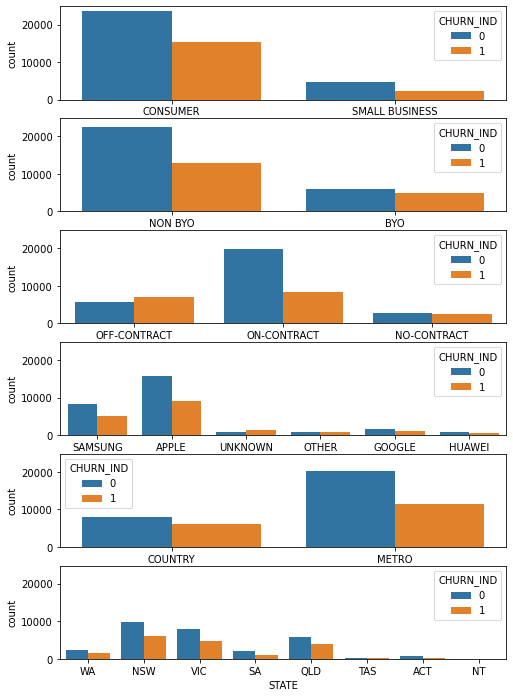

In [21]:
# visulaize distribution of CHURN_IND by categorical variables
fig, ax =plt.subplots(6,1, figsize=(8,12),sharey=True)
sns.countplot(x="CFU", hue="CHURN_IND", data=clean_churn, ax=ax[0])
sns.countplot(x="BYO_PLAN_STATUS", hue="CHURN_IND", data=clean_churn,ax=ax[1])
sns.countplot(x="CONTRACT_STATUS", hue="CHURN_IND", data=clean_churn,ax=ax[2])
sns.countplot(x="HANDSET_USED_BRAND", hue="CHURN_IND", data=clean_churn,ax=ax[3])
sns.countplot(x="COUNTRY_METRO_REGION", hue="CHURN_IND", data=clean_churn,ax=ax[4])
sns.countplot(x="STATE", hue="CHURN_IND", data=clean_churn,ax=ax[5])

## Building Prediction Model
### Create Dummy Variables for Categorical Variables for running Logistic Regression

In [22]:
# create dummy variables
cat_vars=['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS','HANDSET_USED_BRAND','COUNTRY_METRO_REGION','STATE']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(clean_churn[var], prefix=var)
    data=clean_churn.join(cat_list)
    clean_churn=data

In [23]:
cat_vars=['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS','HANDSET_USED_BRAND','COUNTRY_METRO_REGION','STATE']
data_vars=clean_churn.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [24]:
clean_churn_final=clean_churn[to_keep]
clean_churn_final.columns.values

array(['CUST_ID', 'ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE',
       'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'PLAN_TENURE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'PREV_CONTRACT_DURATION', 'CHURN_IND', 'MONTHLY_SPEND',
       'CFU_CONSUMER', 'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO',
       'BYO_PLAN_STATUS_NON BYO', 'CONTRACT_STATUS_NO-CONTRACT',
       'CONTRACT_STATUS_OFF-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT',
       'HANDSET_USED_BRAND_APPLE', 'HANDSET_USED_BRAND_GOOGLE',
       'HANDSET_USED_BRAND_HUAWEI', 'HANDSET_USED_BRAND_OTHER',
       'HANDSET_USED_BRAND_SAMSUNG', 'HANDSET_USED_BRAND_UNKNOWN',
       'COUNTRY_METRO_REGION_COUNTRY', 'COUNTRY_METRO_REGION_METRO',
       'STATE_ACT', 'STATE_NSW', 'STATE_NT', 'STATE_QLD', 'STATE_SA',
       'STATE_TAS', 'STATE_VIC', 'STATE_WA'], dtype=object)

In [25]:
clean_churn_final.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,...,COUNTRY_METRO_REGION_COUNTRY,COUNTRY_METRO_REGION_METRO,STATE_ACT,STATE_NSW,STATE_NT,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC,STATE_WA
count,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,...,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,42336.772498,45.886856,1.554426,41.413576,50.364234,51.361234,10.850890,8.235090,20.351118,15.253192,...,0.311401,0.688599,0.021658,0.343335,0.000672,0.209574,0.063997,0.006504,0.270774,0.083487
std,22102.538850,33.073946,0.834363,15.261213,51.943989,20.854056,9.771842,8.339843,8.032833,10.981573,...,0.463071,0.463071,0.145564,0.474827,0.025916,0.407009,0.244751,0.080384,0.444364,0.276620
min,1.000000,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24950.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43262.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61136.500000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Logistic Regression and Recursive Feature Elimination (RFE)

Use RFE to select features for analysis.

In [26]:
# Split the data into training(80%) and testing data (20%)
train, test = train_test_split(clean_churn_final, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36901, 35)
(9226, 35)


In [27]:
# Set data and predict variable for building prediction model
X_train = train.drop(['CUST_ID', 'CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CUST_ID', 'CHURN_IND'], axis=1)
y_test = test['CHURN_IND']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (36901, 33)
y_train shape:  (36901,)
X_test shape:  (9226, 33)
y_test shape:  (9226,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
19964              37                  2  41.0              37   
22379              72                  1  28.0              72   
7788               83                  1  55.0              83   
44352              94                  1  34.0             178   
17535              83                  1  45.0              83   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
19964            54.54           13                            11   
22379            54.54            3                            21   
7788             17.27            3                             0   
44352            72.72            9                            15   
17535            54.5

In [28]:
# calculate accuracy score by incrementing number of features once at a time
acc_scores = []
for i in range(1,34):
    logReg_model = LogisticRegression()
    rfe = RFE(estimator=logReg_model, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print it
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6375460654671581
Acc on test set using 2 features:  0.6375460654671581
Acc on test set using 3 features:  0.6608497723823976
Acc on test set using 4 features:  0.6541296336440494
Acc on test set using 5 features:  0.6557554736613918
Acc on test set using 6 features:  0.6565141990028182
Acc on test set using 7 features:  0.6565141990028182
Acc on test set using 8 features:  0.6564058096683286
Acc on test set using 9 features:  0.6565141990028182
Acc on test set using 10 features:  0.6565141990028182
Acc on test set using 11 features:  0.6564058096683286
Acc on test set using 12 features:  0.6565141990028182
Acc on test set using 13 features:  0.6558638629958812
Acc on test set using 14 features:  0.6570561456752656
Acc on test set using 15 features:  0.657381313678734
Acc on test set using 16 features:  0.657381313678734
Acc on test set using 17 features:  0.657164535009755
Acc on test set using 18 features:  0.6582484283546499
Acc on test set using 

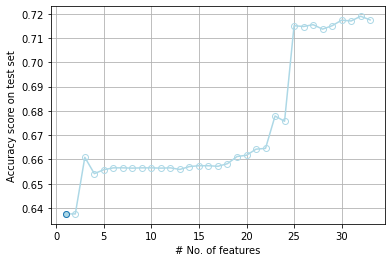

In [29]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 34):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 34), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

From the above plot and accuracy scores, it is observed that the accuracy scores jump to 0.715 when 25 features are selected and level off when additional features are added to the model.
Therefore, 25 features will be selected.

In [30]:
# RFE
logReg_model = LogisticRegression()
rfe = RFE(estimator=logReg_model, n_features_to_select=25, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=25)

In [31]:
# summarize all features and see which features are selected
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 6.000
Column: 4, Selected False, Rank: 8.000
Column: 5, Selected False, Rank: 3.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected False, Rank: 9.000
Column: 25, Selected True, Ran

In [32]:
# select those columns of the 25 features to be analysed
cols=['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND',
       'CFU_CONSUMER', 'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO',
       'BYO_PLAN_STATUS_NON BYO', 'CONTRACT_STATUS_NO-CONTRACT',
       'CONTRACT_STATUS_OFF-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT',
       'HANDSET_USED_BRAND_APPLE', 'HANDSET_USED_BRAND_GOOGLE',
       'HANDSET_USED_BRAND_HUAWEI', 'HANDSET_USED_BRAND_OTHER',
       'HANDSET_USED_BRAND_SAMSUNG', 'HANDSET_USED_BRAND_UNKNOWN',
       'COUNTRY_METRO_REGION_COUNTRY','STATE_ACT', 'STATE_NSW','STATE_QLD','STATE_TAS','STATE_WA'] 
X=X_train[cols]
y=y_train

In [33]:
# run logistic regression model and check the significance of the variables
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit_regularized()
print(result.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5431051909689728
            Iterations: 116
            Function evaluations: 130
            Gradient evaluations: 116
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.184     
Dependent Variable:           CHURN_IND                AIC:                      40132.2493
Date:                         2021-10-14 21:52         BIC:                      40345.1492
No. Observations:             36901                    Log-Likelihood:           -20041.   
Df Model:                     24                       LL-Null:                  -24565.   
Df Residuals:                 36876                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               116.0000                                                    

In [34]:
# drop those variables with p value greater than 0.05 and run the logistic regression model again
cols=['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND', 
      'COUNTRY_METRO_REGION_COUNTRY', 'STATE_ACT', 'STATE_QLD', 'STATE_WA'] 
X=X_train[cols]
y=y_train
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.560566
         Iterations 6
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.158     
Dependent Variable:     CHURN_IND            AIC:                  41388.8803
Date:                   2021-10-14 21:52     BIC:                  41465.5243
No. Observations:       36901                Log-Likelihood:       -20685.   
Df Model:               8                    LL-Null:              -24565.   
Df Residuals:           36892                LLR p-value:          0.0000    
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         6.0000                                               
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

Build prediction model using the below final selected features:
* ACCOUNT_TENURE
* AGE
* MONTHS_OF_CONTRACT_REMAINING
* LAST_FX_CONTRACT_DURATION     
* MONTHLY_SPEND                 
* COUNTRY_METRO_REGION_COUNTRY 
* STATE_ACT                    
* STATE_QLD                    
* STATE_WA   

**Interpretations:**  
_(For e^β is the odds ratio)_
- An increase of 1 month of **account tenure** is associated with (e^{-0.0137}-1) = 1.36% _less_ likely to chrun.
- An increase of 1 year of **age** is associated with (e^{-0.0088}-1) = 0.876% _less_ likely to chrun.
- An increase of 1 **month of contract remaining** is associated with (e^{-0.1299}-1) = 12.2% _less_ likely to chrun.
- An increase of 1 month of **last fixed contract duration** is associated with (e^{0.0258}-1) = 2.61% _more_ likely to chrun.
- An increase of $1 of **monthly spending** is associated with (e^{0.0108}-1) = 1.09% _more_ likely to chrun.
- Customers in **country region** is (e^{0.3010}-1) = 35.1% _more_ likely to chrun than customers in the metro region.
- Customers in the **Australian Capital Territory** (ACT) is (e^{-0.2336}-1) = 20.8% _less_ likely to chrun than customers not in ACT.
- Customers in **Queensland** (QLD) is (e^{0.1059}-1) = 11.2% _more_ likely to chrun than customers not in QLD.
- Customers in **Western Australia** (WA) is (e^{0.0862}-1) = 9% _more_ likely to churn than customers not in WA.


## Evaluation of the Model

In [35]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
# Make predictions on entire test data
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression on test set: 0.71


In [37]:
# Confusion Matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3829  766]
 [1341 1445]]


The Confusion Matrix tells us that we have 3829+1445=5274 correct predictions and 766+1341=2107 incorrect predictions.

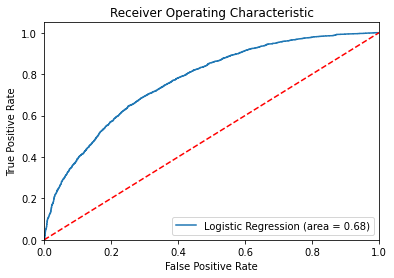

In [38]:
# Receiver Operating Characteristic (ROC) curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The area under the ROC curve indicates it is a good classifier.